In this notebook the individual stages of learning of Gobnilp are shown. We start by creating a Gobnilp object, printing out (the tuple of) stages and also the stage we are in just after creating the Gobnilp object.

In [1]:
from pygobnilp.gobnilp import Gobnilp
m = Gobnilp()
print(m.stages)
print(m.stage)

Using license file /home/james/gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter CutPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter GomoryPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ZeroHalfCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPGapAbs to 0.0
   Prev: 1e-10  Min: 0.0  Max: inf  Default: 1e-10
('no data', 'data', 'local scores', 'MIP model', 'MIP solution', 'BN(s)', 'CPDAG(s)', 'output shown', 'output written')
Gobnilp stage = no data, Gurobi status = 1


So we start at the `no data` stage, so let's get some data. A typical way to obtain data is to read it in from a file, so let's do that and stop the learning process at the next stage, by specifying that next stage - `data` - as the `end` of the learning process.

In [2]:
m.learn('discrete.dat',end='data')

Now we have data, it can be inspected.

In [3]:
print('The type of the "data" attribute is {0}'.format(type(m.data)))
print('The type of the "rawdata" attribute is {0}'.format(type(m.rawdata)))
print('The variables for the data are {0}'.format(m.data_variables))
print('Here are the first two datapoints:\n{0}'.format(m.data[:2]))
print('Here are the first two datapoints:\n{0}'.format(m.rawdata[:2]))

The type of the "data" attribute is <class 'pandas.core.frame.DataFrame'>
The type of the "rawdata" attribute is <class 'numpy.ndarray'>
The variables for the data are ('A', 'B', 'C', 'D', 'E', 'F')
Here are the first two datapoints:
   A  B  C  D  E  F
0  0  0  0  0  0  0
1  0  1  1  0  0  0
Here are the first two datapoints:
[[0 0 0 0 0 0]
 [0 1 1 0 0 0]]


So the data can either be accessed as a Pandas dataframe or a Numpy array. Use whichever
is more convenient. We can now move on another stage by computing local scores. We specify that we `start` at the `data` stage. Had we not done that the default of `start='no data'` would be used (and since no data is specified an error would be raised).

In [4]:
m.learn(start='data',end='local scores')
print(m.local_scores.keys())
print(m.local_scores['A'])

dict_keys(['A', 'B', 'C', 'D', 'E', 'F'])
{frozenset(): -5502.137377150637, frozenset({'B'}): -4349.791324894952, frozenset({'D'}): -4376.2801910701055, frozenset({'E'}): -5289.02870426271, frozenset({'D', 'B'}): -3504.4066187025273, frozenset({'D', 'C'}): -3589.495045030806, frozenset({'D', 'E'}): -4244.150479815038, frozenset({'F', 'E'}): -5288.503190060048, frozenset({'D', 'C', 'B'}): -3013.608073856336}


Next we can construct a MIP model - creating MIP variables and constraints. Let's do that, and then print out the dictionary of family variables with child A and then inspect and alter the MIP family variable which indicates that A has B as its only parent.

In [5]:
m.learn(start='local scores',end='MIP model')
print(m.family['A'])
v = m.family['A'][frozenset(['B'])]
print(v,v.lb,v.ub,v.Obj)
v.lb = 1   # fix variable to 1 by setting 1 as its lower bound
m.update() # have to update now for new lower bound to take effect immediately
print(v,v.lb,v.ub,v.Obj)

{frozenset(): <gurobi.Var A<-{}>, frozenset({'B'}): <gurobi.Var A<-{B}>, frozenset({'D'}): <gurobi.Var A<-{D}>, frozenset({'E'}): <gurobi.Var A<-{E}>, frozenset({'D', 'B'}): <gurobi.Var A<-{B,D}>, frozenset({'D', 'C'}): <gurobi.Var A<-{C,D}>, frozenset({'D', 'E'}): <gurobi.Var A<-{D,E}>, frozenset({'F', 'E'}): <gurobi.Var A<-{E,F}>, frozenset({'D', 'C', 'B'}): <gurobi.Var A<-{B,C,D}>}
<gurobi.Var A<-{B}> 0.0 1.0 -4349.791324894952
<gurobi.Var A<-{B}> 1.0 1.0 -4349.791324894952


Now let's solve the MIP instance. Before doing so we set the attribute `Params.OutputFlag` to `True` so we can see Gurobi at work. `Params.OutputFlag` is an attribute of the Gurobi Model class which we can access since the Gobnilp class is a subclass of the Gurobi Model class. 

In [6]:
m.Params.OutputFlag = True
m.learn(start='MIP model',end='MIP solution')

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1


Since this is an easy problem it is solved immediately. We can then see which variables have been set to non-zero values, using the `X` attribute of each variable:

In [7]:
for x in m.getVars():
    if x.X > 0:
        print(x)

<gurobi.Var A<-{B} (value 1.0)>
<gurobi.Var B<-{} (value 1.0)>
<gurobi.Var C<-{} (value 1.0)>
<gurobi.Var D<-{A,C} (value 1.0)>
<gurobi.Var E<-{B,F} (value 1.0)>
<gurobi.Var F<-{} (value 1.0)>
<gurobi.Var A->D (value 1.0)>
<gurobi.Var B->A (value 1.0)>
<gurobi.Var B->E (value 1.0)>
<gurobi.Var C->D (value 1.0)>
<gurobi.Var F->E (value 1.0)>
<gurobi.Var A-B (value 1.0)>
<gurobi.Var A-D (value 1.0)>
<gurobi.Var B-E (value 1.0)>
<gurobi.Var C-D (value 1.0)>
<gurobi.Var E-F (value 1.0)>


Sure enough, the family variable `A<-{B}` which we fixed to 1 is set to 1 in the solution obtained. Note that as well as family variables Gobnilp has created arrow and undirected edge indicator variables. 

The next stage is to convert the MIP solution into a BN, which we can then print out and plot.

<class 'pygobnilp.gobnilp.BN'>
**********
BN has score -24028.0947783535
**********
A<-B -4349.791324894952
B<- -4841.285573475907
C<- -3501.5105385969146
D<-A,C -3555.014444236549
E<-B,F -4310.304956470649
F<- -3470.18794067853
**********
bnlearn modelstring = 
[A|B][B][C][D|A:C][E|F:B][F]


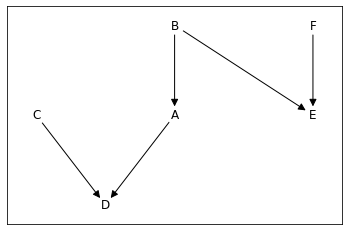

In [8]:
m.learn(start='MIP solution',end='BN(s)')
print(type(m.learned_bn))
print(m.learned_bn)
m.learned_bn.plot()

Next we can create a CPDAG to represent the Markov equivalence class containing the learned BN. The CPDAG is just the BN where we compute which edges are *compelled* to take the same direction in each Markov equivalent BN. Once this has been done (by progressing from the 'BN(s)' stage to the 'CPDAG(s)' stage) we can use the cpdag_str method to get a string representation of the CPDAG and if we plot the BN the compelled edges will be in red.

**********
CPDAG:
Vertices: A,B,C,D,E,F
A->D
B-A
B->E
C->D
F->E



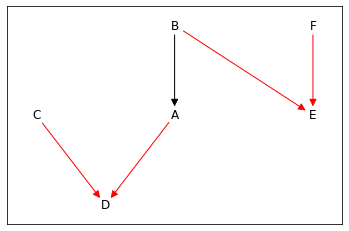

In [9]:
m.learn(start='BN(s)',end='CPDAG(s)')
print(m.learned_bn.cpdag_str())
m.learned_bn.plot()

A CPDAG has directed and undirected edges, but in the plot of the CPDAG we only see directed ones which are either black or red. The black edges in the CPDAG should be interpreted as undirected. The reason for plotting the CPDAG in this non-standard manner is that it allows one plot to represent both the learned BN (just ignore the colours) and the learned CPDAG (interpret black edges as undirected).

The last Gobnilp stages are `output_shown` and `output_written` but since we have already 'manually' shown the output there is no reason here to progress to those stages.